In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


## Loading the dataset
The dataset is given in a zip file. So to use this at first we have to **unzip** the zip files.

In [2]:
import zipfile
import os
import shutil

In [3]:
# Removing files that are allready unzippped
for folder in os.listdir("/kaggle/working/"):
    if folder != "__notebook_source__.ipynb":
        shutil.rmtree("/kaggle/working/"+folder)

# Unzip train data
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip") as zip_ref:
    zip_ref.extractall("/kaggle/working/train")

# Unzip test data
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip") as zip_ref:
    zip_ref.extractall("/kaggle/working/test")

Seperate cats and dogs images in train data

In [4]:
TRAIN_DIR = "/kaggle/working/train/"
TEST_DIR = "/kaggle/working/test/"

# Creating separate folder for cat and dog images
# Using try catch so that if the folder is already created, then it won't throw any error
try:
    os.mkdir(TRAIN_DIR + "cat")
    os.mkdir(TRAIN_DIR + "dog")
except os.error:
    pass

# Seperating training data
for image in os.listdir(TRAIN_DIR + "train"):
    source = TRAIN_DIR + "train/" + image
    destination = TRAIN_DIR + image.split(".")[0]
    shutil.move(source, destination)

# Test data can't be sepearated, so putting them in one folder
for image in os.listdir(TEST_DIR + "test1"):
    source = TEST_DIR + "test1/" + image
    destination = TEST_DIR
    shutil.move(source, destination)

# Removing the empty folders
os.rmdir(TRAIN_DIR + "train")
os.rmdir(TEST_DIR + "test1")

## Exploring the dataset

In [5]:
DOG_DIR = "/kaggle/working/train/dog/"
CAT_DIR = "/kaggle/working/train/cat/"

TEST_FILES = os.listdir(TEST_DIR)
CAT_FILES = os.listdir(CAT_DIR)
DOG_FILES = os.listdir(DOG_DIR)

TEST_DATA_SIZE = len(TEST_FILES)
DOG_DATA_SIZE = len(DOG_FILES)
CAT_DATA_SIZE = len(CAT_FILES)

print(f"There are {DOG_DATA_SIZE} dog, {CAT_DATA_SIZE} cat and {TEST_DATA_SIZE} test images.")

There are 12500 dog, 12500 cat and 12500 test images.


Showing some images from the dataset

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

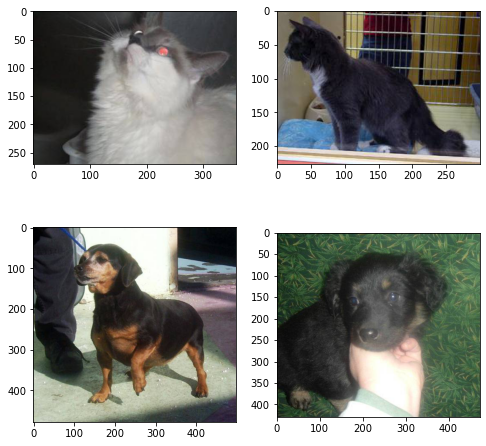

In [7]:
# Getting random indexes
cat1, cat2, dog1, dog2 = [random.randint(0, CAT_DATA_SIZE-1) for i in range(4)]

# Showing the images on a subplot
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,8))

axes[0, 0].imshow(mpimg.imread(CAT_DIR + CAT_FILES[cat1]))
axes[0, 1].imshow(mpimg.imread(CAT_DIR + CAT_FILES[cat2]))
axes[1, 0].imshow(mpimg.imread(DOG_DIR + DOG_FILES[dog1]))
axes[1, 1].imshow(mpimg.imread(DOG_DIR + DOG_FILES[dog2]))

## Time to create the model
This time I'm going to create my model from scratch usign only CNN and MaxPool.

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras.models import Sequential

In [9]:
model = Sequential([
    Input((150, 150, 3)),
    Conv2D(16, 3, activation="relu"),
    MaxPool2D(2, 2),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(2, 2),
    Conv2D(64, 3, activation="relu"),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

My model has only 3 Conv2D layers followed by MaxPool2D layers. And 2 Dense layer on top of that.

## Loading and Augmenting images

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(150, 150),
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary",
                                              subset="training")

validation_gen = train_datagen.flow_from_directory(TRAIN_DIR,
                                                   target_size=(150, 150),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode="binary",
                                                   subset="validation")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Train the model on augmented images

In [12]:
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    validation_data=validation_gen,
                    validation_steps=validation_gen.samples // BATCH_SIZE)

Epoch 1/10
625/625 [==============================] - 277s 443ms/step - loss: 0.6422 - accuracy: 0.6209 - val_loss: 0.5797 - val_accuracy: 0.6941
Epoch 2/10
625/625 [==============================] - 272s 436ms/step - loss: 0.5860 - accuracy: 0.6836 - val_loss: 0.5505 - val_accuracy: 0.7119
Epoch 3/10
625/625 [==============================] - 273s 436ms/step - loss: 0.5529 - accuracy: 0.7185 - val_loss: 0.5258 - val_accuracy: 0.7328
Epoch 4/10
625/625 [==============================] - 272s 436ms/step - loss: 0.5317 - accuracy: 0.7326 - val_loss: 0.5082 - val_accuracy: 0.7518
Epoch 5/10
625/625 [==============================] - 275s 440ms/step - loss: 0.5104 - accuracy: 0.7454 - val_loss: 0.5094 - val_accuracy: 0.7514
Epoch 6/10
625/625 [==============================] - 272s 436ms/step - loss: 0.5035 - accuracy: 0.7554 - val_loss: 0.5000 - val_accuracy: 0.7596
Epoch 7/10
625/625 [==============================] - 272s 435ms/step - loss: 0.4839 - accuracy: 0.7655 - val_loss: 0.4634 -

Let's see how our model performed

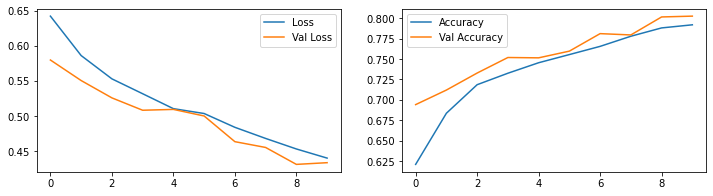

In [13]:
# Plotting loss and accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].plot(history.history["loss"], label="Loss")
axes[0].plot(history.history["val_loss"], label="Val Loss")
axes[1].plot(history.history["accuracy"], label="Accuracy")
axes[1].plot(history.history["val_accuracy"], label="Val Accuracy")
axes[0].legend()
axes[1].legend()
fig.show()

Well, atleast it isn't overfitted. 😛

## Getting the test files ready to predict

In [16]:
import pandas as pd

In [17]:
test_df = pd.DataFrame({'filename': TEST_FILES})

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            TEST_DIR,
                                            x_col="filename",
                                            y_col=None,
                                            class_mode=None,
                                            target_size=(150, 150),
                                            shuffle=False,
                                            batch_size=BATCH_SIZE)

Found 12500 validated image filenames.


## Predict

In [38]:
predict = model.predict(test_gen, steps=np.ceil(test_df.shape[0] / BATCH_SIZE))

As I've used softmax for binary classification, this will predict a float value (0 to 1) for every test image.

In [55]:
output = (predict >= 0.5).astype(int)
# As output was a 2D array, I had to squeeze it
output = np.squeeze(output).tolist()

I took 1 if the prediction is greater or equal to 0.5, else I took 0.
Here 1 means it's a dog, and 0 means it's a cat.

In [56]:
# Creating the label map for categories
label_map = dict((v, k) for k, v in train_gen.class_indices.items())
CATEGORY = [label_map[i] for i in output]

TEST_ID = []
for file in TEST_FILES:
    TEST_ID.append(file.split('.')[0])

In [57]:
# Creating the dataframe for submission
submission_df = pd.DataFrame({
    "id": TEST_ID,
    "label": CATEGORY
})

submission_df.to_csv("submission.csv", index=False)